# Train

In order to make steering decision, we want the drone to be able to "see" the path in front of it. To achieve this we'll train a convolutional neural net.

## Imports

In [1]:
from datetime import datetime

import matplotlib.pyplot as plt
import numpy as np

import tensorflow as tf
from tensorflow.python.distribute.tpu_strategy import TPUStrategy
import segmentation_models as sm

Segmentation Models: using `tf.keras` framework.


In [2]:
# Convenience methods
from visualise import show_two, show
from tpu import resolve_tpu_strategy, get_tpu_devices
from dataset import load_dataset, split_dataset_paths

## Set up TPU

To speed up model training, we use [Google Cloud Platform](https://cloud.google.com/)'s "[TPU's](https://cloud.google.com/tpu)". TPU's use a machine learning ASIC.

In [3]:
tpu_strategy = resolve_tpu_strategy('padnet')

INFO:tensorflow:Initializing the TPU system: padnet


INFO:tensorflow:Initializing the TPU system: padnet


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Found TPU system:


INFO:tensorflow:Found TPU system:


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


In [4]:
nbro_tpu_devices = len(get_tpu_devices())
print(f"{nbro_tpu_devices} TPU devices connected!")

8 TPU devices connected!


In [5]:
# PARALLEL_OPS = tf.data.experimental.AUTOTUNE
PARALLEL_OPS = None

## Prepare dataset

TODO: Explain where we got the Freiburg dataset

In [6]:
IMAGE_SIZE = [448, 640]

In [7]:
GCS_PATTERN = 'gs://padnet-data/freiburg/tfr/*.tfr'
paths = tf.io.gfile.glob(GCS_PATTERN)

In [8]:
TRAIN_RATIO = 0.7
VALIDATION_RATIO = 0.15
train_paths, validate_paths, test_paths = split_dataset_paths(paths, TRAIN_RATIO, VALIDATION_RATIO)
print(f"Found {len(paths)} tfrs. Splitting into {len(train_paths)} training, {len(validate_paths)} validation, and {len(test_paths)} test tfrs")

Found 230 tfrs. Splitting into 161 training, 34 validation, and 35 test tfrs


## Visualise dataset

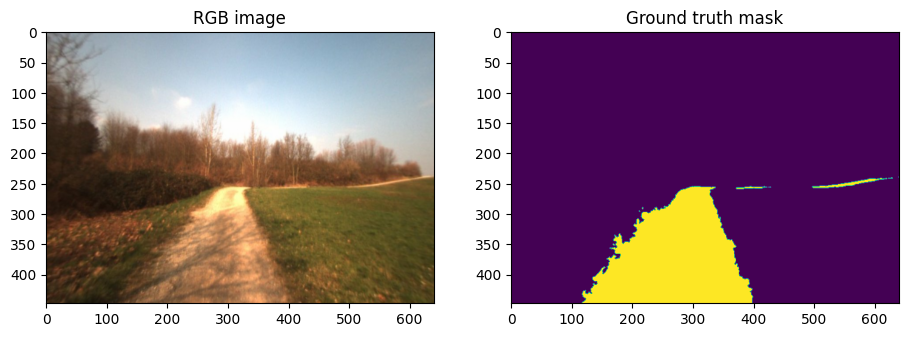

In [9]:
visualisation_dataset = load_dataset(train_paths, IMAGE_SIZE, PARALLEL_OPS)
sample_rgb, sample_gt = next(iter(visualisation_dataset))
show_two("RGB image", sample_rgb, "Ground truth mask", sample_gt)

## Load dataset

In [10]:
BATCH_SIZE = 16  # Using TPU v3-8 device => must be divisible by 8 for sharding

In [11]:
# Dataset generation *must* come after tpu resolution
training_dataset = load_dataset(train_paths, IMAGE_SIZE, PARALLEL_OPS) \
    .repeat() \
    .batch(BATCH_SIZE)
validation_dataset = load_dataset(validate_paths, IMAGE_SIZE, PARALLEL_OPS)\
    .batch(BATCH_SIZE)

## Create model

In [12]:
def create_model(tpu_strategy: TPUStrategy = None) -> tf.keras.Model:
    BACKBONE = 'efficientnetb3'
    CLASSES = ['path']
    LR = 0.0001

    n_classes = 1 if len(CLASSES) == 1 else (len(CLASSES) + 1)  # case for binary and multiclass segmentation
    activation = 'sigmoid' if n_classes == 1 else 'softmax'

    def scoped_create_model():
        dice_loss = sm.losses.DiceLoss()
        focal_loss = sm.losses.BinaryFocalLoss() if n_classes == 1 else sm.losses.CategoricalFocalLoss()
        total_loss = dice_loss + (1 * focal_loss)

        optim = tf.keras.optimizers.Adam(LR)

        metrics = [sm.metrics.IOUScore(threshold=0.5), sm.metrics.FScore(threshold=0.5)]

        model: tf.keras.Model = sm.Unet(BACKBONE, classes=n_classes, activation=activation)
        model.compile(optim, total_loss, metrics)
        # model.compile(optim, total_loss)
        return model

    if tpu_strategy is not None:
        with tpu_strategy.scope():
            return scoped_create_model()
    else:
        return scoped_create_model()

In [13]:
model = create_model(tpu_strategy)

## Train model

In [14]:
steps_per_epoch = (len(train_paths) // BATCH_SIZE) * 10 # Arbitrary amount of extra augmentations per image
validation_steps = len(validate_paths) // BATCH_SIZE

print(f"With a batch size of {BATCH_SIZE}, there will be {steps_per_epoch} batches per training epoch and {validation_steps} batches per validation run.")

With a batch size of 16, there will be 100 batches per training epoch and 2 batches per validation run.


In [15]:
tensorboard_log_dir = "gs://padnet-data/model/" + datetime.now().strftime("%Y-%m-%dT%H:%M:%S")
callbacks = [
    tf.keras.callbacks.ModelCheckpoint('./best_model.h5', save_weights_only=True, save_best_only=True, mode='min'),
    tf.keras.callbacks.ReduceLROnPlateau(),
    tf.keras.callbacks.TensorBoard(log_dir=tensorboard_log_dir, histogram_freq=1),
    #early stopping
    tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0.001, patience=3)
]

In [16]:
EPOCHS = 40

In [17]:
history = model.fit(
    x=training_dataset,
    epochs=EPOCHS,
    steps_per_epoch=steps_per_epoch,
    callbacks=callbacks,
    validation_data=validation_dataset,
    validation_steps=validation_steps
)
model.save('gs://padnet-data/trained_models/no_aug.h5')

model.summary()



Epoch 1/40
100/100 [==============================] - 224s 1s/step - loss: 0.7952 - iou_score: 0.4034 - f1-score: 0.5326 - val_loss: 0.7753 - val_iou_score: 0.5061 - val_f1-score: 0.6616
Epoch 2/40
100/100 [==============================] - 64s 648ms/step - loss: 0.5138 - iou_score: 0.9008 - f1-score: 0.9469 - val_loss: 0.5554 - val_iou_score: 0.6984 - val_f1-score: 0.8169
Epoch 3/40
100/100 [==============================] - 65s 653ms/step - loss: 0.3543 - iou_score: 0.9370 - f1-score: 0.9673 - val_loss: 0.3496 - val_iou_score: 0.8738 - val_f1-score: 0.9315
Epoch 4/40
100/100 [==============================] - 62s 620ms/step - loss: 0.2445 - iou_score: 0.9469 - f1-score: 0.9726 - val_loss: 0.2394 - val_iou_score: 0.8913 - val_f1-score: 0.9417
Epoch 5/40
100/100 [==============================] - 46s 459ms/step - loss: 0.1690 - iou_score: 0.9550 - f1-score: 0.9769 - val_loss: 0.1775 - val_iou_score: 0.8958 - val_f1-score: 0.9442
Epoch 6/40
100/100 [==============================] - 45s

OSError: Unable to create file (unable to open file: name = 'gs://padnet-data/model/no_aug.h5', errno = 2, error message = 'No such file or directory', flags = 13, o_flags = 242)

## Metrics

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

## Test model

In [ ]:
test_dataset = load_dataset(test_paths, IMAGE_SIZE, PARALLEL_OPS)

In [ ]:
test_lst = list(test_dataset)

In [ ]:
NBRO_TEST_CASES = 5

In [ ]:
test_sample_rgbs, test_sample_gts = zip(*test_lst[:NBRO_TEST_CASES])

In [ ]:
predictions = model(np.asarray(test_sample_rgbs))

In [ ]:
for test_sample_rgb, prediction, test_sample_gt in zip(test_sample_rgbs, predictions, test_sample_gts):
    show({
        "RGB image": test_sample_rgb,
        "Prediction": prediction,
        "Ground truth mask": test_sample_gt
    })